In [1]:
from keras.applications import MobileNet

In [2]:
#MOBILE NET WAS DESIGNED TO WORK ON 224 *  224 DATASET

In [4]:
img_rows, img_cols = (224 ,224)

## Reload the MobileNet Model without the F.C. Layers

In [5]:
mobile_net = MobileNet(input_shape=(img_rows,img_cols,3),weights="imagenet",include_top=False)

17227776/17225924 [==============================] - 15s 1us/step


In [6]:
for layer in mobile_net.layers:
    layer.trainable = False

In [7]:
for (i,layer) in enumerate(mobile_net.layers):
    print(str(i)+ " " + layer.__class__.__name__,  layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

### Create the top model

In [8]:
def addTopModelMobileNet(bottom_model,num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,MaxPooling2D,Dropout,Activation,GlobalAveragePooling2D

In [10]:
from keras.layers import Conv2D, ZeroPadding2D

In [11]:
from keras.layers.normalization import BatchNormalization

In [12]:
from keras.models import Model

In [13]:
num_classes = 10

In [14]:
FC_head = addTopModelMobileNet(mobile_net,num_classes)

In [15]:
model = Model(inputs = mobile_net.input,outputs = FC_head)

In [17]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## load your dataset

In [18]:
from keras.preprocessing.image import ImageDataGenerator 

In [19]:
train_data_dir = './monkey_breed/train'
validation_data_dir = './monkey_breed/validation/' 

## DATA AUGMENTATION

In [20]:
train_data_gen = ImageDataGenerator(rescale = 1./255,rotation_range = 45,width_shift_range=0.3,height_shift_range=0.3,horizontal_flip=True,fill_mode='nearest')

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
#set batch size
batch_size = 32

In [23]:
train_generator = train_data_gen.flow_from_directory(train_data_dir,target_size=(img_rows,img_cols),batch_size=batch_size,class_mode='categorical')

Found 1098 images belonging to 10 classes.


In [24]:
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size=(img_rows,img_cols),batch_size=batch_size,class_mode='categorical')

Found 272 images belonging to 10 classes.


## TRAINING MODEL

In [25]:
from keras.optimizers import RMSprop

In [26]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [31]:
checkpoint = ModelCheckpoint("Transfer_learning_MOBILENET.h5",monitor='val_loss',mode='min',save_best_only=True)

In [32]:
early_stop = EarlyStopping(monitor='val_loss',min_delta = 0,patience = 3,verbose =1,restore_best_weights=True)

In [33]:
callbacks = [early_stop,checkpoint]

In [34]:
model.compile(loss='categorical_crossentropy',optimizer = RMSprop(lr=0.001),metrics=['accuracy'])

In [38]:
nb_training_samples = 1097
nb_validation_samples = 272

In [41]:
epochs = 5
batch_size = 32


In [42]:
history = model.fit_generator(train_generator,steps_per_epoch=nb_training_samples//batch_size,epochs = epochs,callbacks = callbacks,validation_data=validation_generator,validation_steps=nb_validation_samples//batch_size)

Epoch 1/5
34/34 [==============================] - 112s 3s/step - loss: 0.6030 - accuracy: 0.8480 - val_loss: 0.3030 - val_accuracy: 0.9023
Epoch 2/5
34/34 [==============================] - 113s 3s/step - loss: 0.4390 - accuracy: 0.8659 - val_loss: 0.4204 - val_accuracy: 0.8633
Epoch 3/5
34/34 [==============================] - 110s 3s/step - loss: 0.3816 - accuracy: 0.8780 - val_loss: 0.5412 - val_accuracy: 0.8906
Epoch 4/5
34/34 [==============================] - 110s 3s/step - loss: 0.4754 - accuracy: 0.8687 - val_loss: 0.3393 - val_accuracy: 0.9102
Epoch 00004: early stopping


In [44]:
plotting = history.history

In [45]:
import pandas as pd

In [46]:
logs = pd.DataFrame(plotting)

In [47]:
logs

,loss,accuracy,val_loss,val_accuracy
0,0.603015,0.848030,0.303013,0.902344
1,0.439046,0.865854,0.420395,0.863281
2,0.381592,0.878049,0.541235,0.890625
3,0.475368,0.868668,0.339295,0.910156


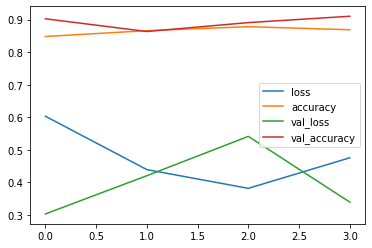

In [48]:
logs.plot()

## SAVE AND LOAD MODEL

In [88]:
from keras.models import load_model

In [89]:
classifer = load_model('./Transfer_learning_MOBILENET.h5')

In [51]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile,join

In [92]:
monkey_breeds_dict = {"[0]" : "mantled_howler",
                     "[1]" : "patas_monkey",
                     "[2]": "bald_uakari",
                     "[3]": "japanses_macaque",
                     "[4]": "pygymy marmoset",
                     "[5]":"white_headed_capuchin",
                     "[6]": "silvery_marmoset",
                     "[7]": "common_squirrel_monkey",
                     "[8]": "black_headed_night_monkey",
                     "[9]": "nilgiri_langur"}

In [94]:
monkey_breeds_dict_n = {"n0" : "mantled_howler",
                     "n1" : "patas_monkey",
                     "n2": "bald_uakari",
                     "n3": "japanses_macaque",
                     "n4": "pygymy marmoset",
                     "n5":"white_headed_capuchin",
                     "n6": "silvery_marmoset",
                     "n7": "common_squirrel_monkey",
                     "n8": "black_headed_night_monkey",
                     "n9": "nilgiri_langur"}

In [95]:
def draw_test(name,pred,im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im,80,0,0,100,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image,monkey,(20,60),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
    cv2.imshow(name,expanded_image)

In [96]:
def get_Random_image(path):
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)),os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class- "+ monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path,f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)


In [97]:
for i in range(0,10):
    input_im = get_Random_image('./monkey_breed/validation/')
    input_original = input_im.copy()
    input_original =  cv2.resize(input_original,None,fx=0.5,fy=0.5,interpolation = cv2.INTER_LINEAR)
    
    
    input_im = cv2.resize(input_original,(224,224),interpolation = cv2.INTER_LINEAR)
    input_im = input_im/255
    input_im = input_im.reshape(1,224,224,3)
    
    
    res = np.argmax(classifer.predict(input_im,1,verbose=0),axis=1)
    
    
    draw_test("Prediction",res,input_original)
    cv2.waitKey(0)
    
    
cv2.destroyAllWindows()

Class- common_squirrel_monkey
Class- white_headed_capuchin
Class- white_headed_capuchin
Class- nilgiri_langur
Class- japanses_macaque
Class- pygymy marmoset
Class- patas_monkey
Class- japanses_macaque
Class- bald_uakari
Class- nilgiri_langur
